# EuroSAT Land Cover Classification (ML Baseline)

This project demonstrates a complete ML baseline for satellite image
classification using the EuroSAT RGB dataset.

- Dataset: EuroSAT RGB
- Task: Land-use / land-cover classification
- Classes: 10
- Model: CNN (baseline)
- Platform: Google Colab


In [11]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [12]:
!rm -rf EuroSAT_RGB eurosat_rgb.zip
!wget -O eurosat_rgb.zip https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip
!unzip -q eurosat_rgb.zip

--2026-02-13 10:57:16--  https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 137.138.52.235, 188.184.103.118, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/7711810/files/EuroSAT_RGB.zip [following]
--2026-02-13 10:57:16--  https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 94658721 (90M) [application/octet-stream]
Saving to: ‘eurosat_rgb.zip’

eurosat_rgb.zip     100%[===================>]  90.27M  27.2MB/s    in 3.3s    

2026-02-13 10:57:20 (27.2 MB/s) - ‘eurosat_rgb.zip’ saved [94658721/94658721]



In [14]:
import os
print(os.listdir("EuroSAT_RGB"))



['Residential', 'AnnualCrop', 'PermanentCrop', 'Forest', 'SeaLake', 'HerbaceousVegetation', 'Highway', 'Industrial', 'River', 'Pasture']


In [15]:
DATASET_PATH = "EuroSAT_RGB"
classes = sorted(os.listdir(DATASET_PATH))

print("Number of classes:", len(classes))
print("Classes:", classes)


Number of classes: 10
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [17]:
IMG_SIZE = 64   # small for fast demo

def load_images(dataset_path, classes, img_size, max_per_class=200):
    X, y = [], []

    for idx, cls in enumerate(classes):
        cls_path = os.path.join(dataset_path, cls)
        images = os.listdir(cls_path)[:max_per_class]

        for img_name in images:
            img_path = os.path.join(cls_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img.flatten())
            y.append(idx)

    return np.array(X), np.array(y)

X, y = load_images(DATASET_PATH, classes, IMG_SIZE)

print("Feature shape:", X.shape)
print("Label shape:", y.shape)


Feature shape: (2000, 12288)
Label shape: (2000,)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)


(1600, 12288) (400, 12288)


In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Reduced feature shape:", X_train_pca.shape)


Reduced feature shape: (1600, 100)


In [21]:
svm = SVC(kernel="rbf", gamma="scale")
svm.fit(X_train_pca, y_train)


SVC()

In [22]:
y_pred = svm.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(
    y_test, y_pred,
    target_names=classes,
    zero_division=0
))


Accuracy: 0.59

Classification Report:

                      precision    recall  f1-score   support

          AnnualCrop       0.45      0.38      0.41        40
              Forest       0.69      0.90      0.78        40
HerbaceousVegetation       0.65      0.38      0.48        40
             Highway       0.54      0.35      0.42        40
          Industrial       0.70      0.75      0.72        40
             Pasture       0.64      0.85      0.73        40
       PermanentCrop       0.38      0.57      0.46        40
         Residential       0.51      0.65      0.57        40
               River       0.52      0.38      0.43        40
             SeaLake       0.93      0.70      0.80        40

            accuracy                           0.59       400
           macro avg       0.60      0.59      0.58       400
        weighted avg       0.60      0.59      0.58       400



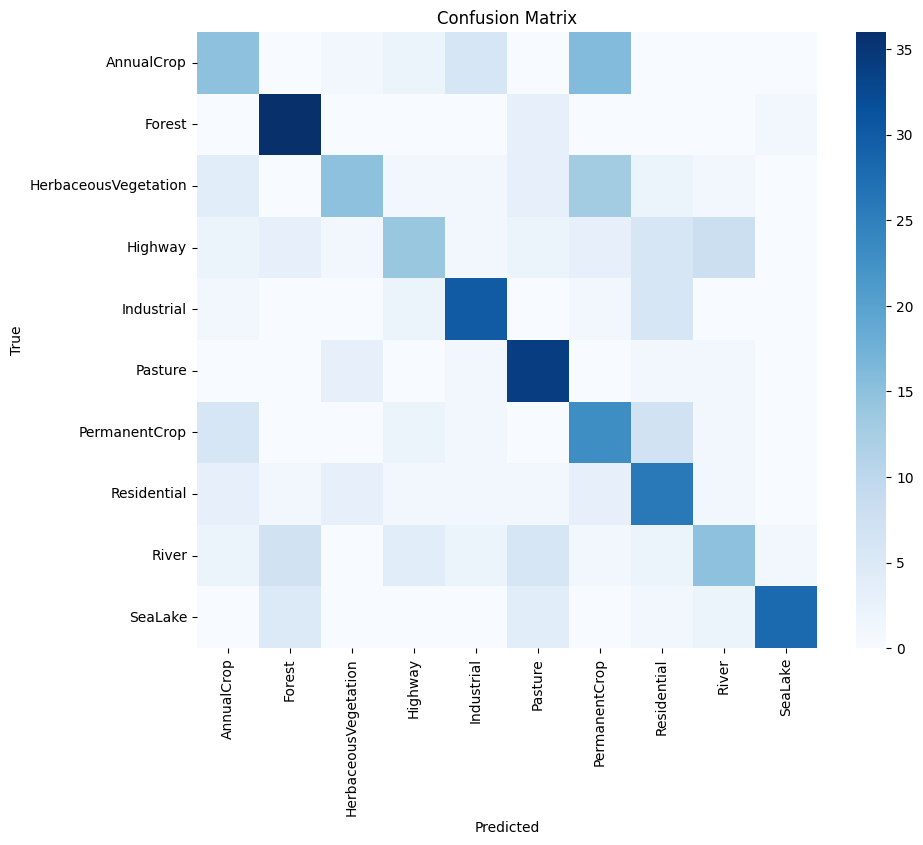

In [23]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    xticklabels=classes,
    yticklabels=classes,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [24]:
# ====== IMPORT LIBRARIES ======
import os
import numpy as np
import cv2
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [25]:
# ====== BASIC CONFIG ======
DATASET_PATH = "EuroSAT_RGB"
IMG_SIZE = 64

# Classes (already confirmed by you)
classes = os.listdir(DATASET_PATH)
print("Classes:", classes)


Classes: ['Residential', 'AnnualCrop', 'PermanentCrop', 'Forest', 'SeaLake', 'HerbaceousVegetation', 'Highway', 'Industrial', 'River', 'Pasture']


In [26]:
# ====== LOAD IMAGES FUNCTION ======
def load_images(dataset_path, classes, img_size):
    X = []
    y = []

    for label in classes:
        class_path = os.path.join(dataset_path, label)
        for img_name in tqdm(os.listdir(class_path), desc=f"Loading {label}"):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(label)

    return np.array(X), np.array(y)


In [27]:
X, y = load_images(DATASET_PATH, classes, IMG_SIZE)

print("X shape:", X.shape)
print("y shape:", y.shape)


Loading Pasture: 100%|██████████| 2000/2000 [00:00<00:00, 3254.85it/s]


X shape: (27000, 64, 64, 3)
y shape: (27000,)


In [28]:
# ====== NORMALIZE ======
X = X / 255.0

# ====== LABEL ENCODING ======
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to categorical
y_cat = to_categorical(y_encoded)

print("Encoded labels shape:", y_cat.shape)


Encoded labels shape: (27000, 10)


In [29]:
# ====== TRAIN TEST SPLIT ======
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (21600, 64, 64, 3) (21600, 10)
Test: (5400, 64, 64, 3) (5400, 10)


In [30]:
# ====== CNN MODEL ======
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,490 (2.61 MB)

 Trainable params: 684,490 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 146s 231ms/step - accuracy: 0.3420 - loss: 1.6752 - val_accuracy: 0.6116 - val_loss: 1.0707
Epoch 2/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 137s 225ms/step - accuracy: 0.6102 - loss: 1.0860 - val_accuracy: 0.7389 - val_loss: 0.7580
Epoch 3/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 133s 219ms/step - accuracy: 0.6956 - loss: 0.8752 - val_accuracy: 0.7731 - val_loss: 0.6573
Epoch 4/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 142s 219ms/step - accuracy: 0.7427 - loss: 0.7405 - val_accuracy: 0.7954 - val_loss: 0.5906
Epoch 5/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 142s 220ms/step - accuracy: 0.7646 - loss: 0.6741 - val_accuracy: 0.8139 - val_loss: 0.5491
Epoch 6/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 141s 219ms/step - accuracy: 0.7921 - loss: 0.6114 - val_accuracy: 0.8130 - val_loss: 0.5346
Epoch 7/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 142s 220ms/step - accuracy: 0.8065 - loss: 0.5658 - val_accuracy: 0.8343 - val_loss: 0.4988
Epoch 8/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 133s 218ms/step - accuracy: 0.8279 -

In [32]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.8454 - loss: 0.4452
Test Accuracy: 0.8444444537162781


In [33]:
model.save("eurosat_cnn_model.h5")
print("Model saved successfully")


Model saved successfully


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

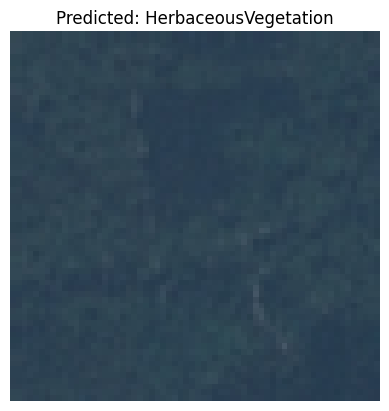

In [34]:
from tensorflow.keras.preprocessing import image

img_path = "EuroSAT_RGB/Forest/Forest_10.jpg"  # change class to test
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = le.inverse_transform([np.argmax(prediction)])

plt.imshow(img)
plt.title(f"Predicted: {predicted_class[0]}")
plt.axis('off')
#Demo prediction

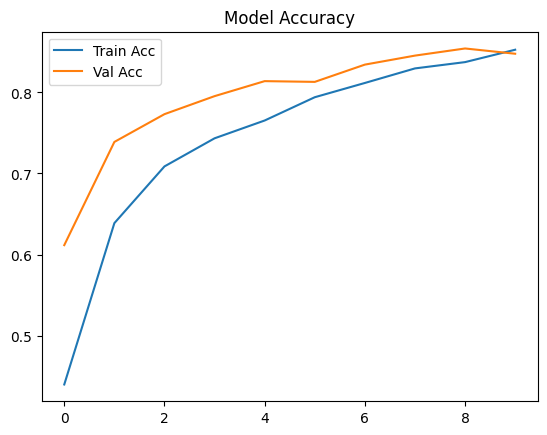

In [35]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Model Accuracy")
plt.show()
